 <font size=7>Loan Approval Prediction

source:  https://www.kaggle.com/competitions/playground-series-s4e10

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e10:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F84894%2F9709193%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T095853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2806429a4ba76d64b3033be47fc1c36a5fc3095bf6b19f2b37966de77abb25e9b020e1ebaa6d4c464a3a30861b3b00d301552cc9d34097db21f3e1d8fc1dbcc47c3b33c9011a088ab1f945e90b35b0d4c307121e63f32a4977544aa8882d5d9ddbceace1b783a797cf020f2ac9fd298b0d061972c115bf02ad1292e50e1ae4e32823aa3d4f4e53764dec3bd6281dafed5684e4a2f5400b82765aae59e199f9baa41b4a92274cec7ef4d2330ac129a43e6dcebc9bc15d05909b26cbc28398c45870ed2badd4004064cf189bb4b5a25768cec4b12a1bd1f018c76bafa5fa4c948e83950546b81ff29f12d875e9493f2b61f328b0b49e0ffe32ab5876ac22cc73ea'


KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1515882 bytes downloaded
Downloaded and uncompressed: playground-series-s4e10
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv


# Aim : Predict whether an applicant is approved for a loan.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

# About the data

The dataset you provided contains information about loan applicants and their loan applications. It can be used to predict whether a loan application will be approved or not. Here's a description of each field:

* **id**: A unique identifier for each loan application.

* **person_age**: The age of the loan applicant.

* **person_income**: The annual income of the loan applicant.

* **person_home_ownership**: Indicates whether the loan applicant owns their home (OWN), rents (RENT), has a mortgage (MORTGAGE) or OTHER.

* **person_emp_length**: The length of time in years the loan applicant has been employed in their current job.

* **loan_intent**: The purpose of the loan, such as EDUCATION, MEDICAL, PERSONAL, VENTURE, DEBT CONSOLIDATION or HOME IMPROVEMENT.

* **loan_grade**: The grade assigned to the loan application based on the applicant's creditworthiness. Grades range from A to G, with A being the best and G being the worst.

* **loan_amnt**: The amount of the loan requested.

* **loan_int_rate**: The interest rate for the loan.

* **loan_percent_income**: The percentage of the loan amount relative to the applicant's annual income.

* **cb_person_default_on_file**: Indicates whether the applicant has defaulted on a loan in the past.

* **cb_person_cred_hist_length**: The length of the applicant's credit history measured in years.

* **loan_status**: The outcome of the loan application, either approved (1) or denied (0).

# Load the data

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0  
4                         N                           3            0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

##### Observations

* No missing values.
* All data types are correct.

# Exploratory Data Analysis

Data Cleaning and Preparation:

Handling missing values: Imputing missing data or removing rows/columns with excessive missing values.

Dealing with outliers: Identifying and addressing outliers that could skew results.

Data normalization or standardization: Transforming data to a common scale to ensure fair comparisons.

Feature engineering: Creating new features from existing ones to potentially improve model performance.

Summary Statistics:

Descriptive statistics: Calculating measures like mean, median, mode, standard deviation, and quartiles to understand data distribution.

Correlation analysis: Identifying relationships between variables using correlation coefficients.

Data Visualization:

Univariate analysis: Visualizing single variables using histograms, box plots, density plots, etc.

Bivariate analysis: Visualizing relationships between two variables using scatter plots, line plots, bar charts, etc.

Multivariate analysis: Visualizing relationships among multiple variables using techniques like pair plots or parallel coordinate plots.

Hypothesis Testing:

Testing assumptions: Checking assumptions underlying statistical tests or modeling techniques.

Hypothesis testing: Formulating hypotheses and using statistical tests to evaluate their validity.

Benefits of EDA:

Better understanding of the data: Gaining insights into data characteristics, distributions, and relationships.

Identifying patterns and trends: Discovering hidden patterns or trends that might not be obvious from raw data.

Detecting anomalies and outliers: Identifying unusual data points that could affect model performance.

Informing feature engineering: Guiding the creation of new features that might be more informative for modeling.

Checking assumptions: Ensuring that the data meets the assumptions of statistical tests or modeling techniques.




# Data Cleaning

In [ ]:
df['loan_status'] = df['loan_status'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          58645 non-null  int64   
 1   person_age                  58645 non-null  int64   
 2   person_income               58645 non-null  int64   
 3   person_home_ownership       58645 non-null  object  
 4   person_emp_length           58645 non-null  float64 
 5   loan_intent                 58645 non-null  object  
 6   loan_grade                  58645 non-null  object  
 7   loan_amnt                   58645 non-null  int64   
 8   loan_int_rate               58645 non-null  float64 
 9   loan_percent_income         58645 non-null  float64 
 10  cb_person_default_on_file   58645 non-null  object  
 11  cb_person_cred_hist_length  58645 non-null  int64   
 12  loan_status                 58645 non-null  category
dtypes: category(1), 

In [ ]:
num_features = df.select_dtypes(include='number').columns.tolist()
num_features = [col for col in num_features if col != 'id']
cat_features = df.select_dtypes(exclude='number').columns.tolist()

In [ ]:
df[num_features].describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  58645.000000   5.864500e+04       58645.000000  58645.000000   
mean      27.550857   6.404617e+04           4.701015   9217.556518   
std        6.033216   3.793111e+04           3.959784   5563.807384   
min       20.000000   4.200000e+03           0.000000    500.000000   
25%       23.000000   4.200000e+04           2.000000   5000.000000   
50%       26.000000   5.800000e+04           4.000000   8000.000000   
75%       30.000000   7.560000e+04           7.000000  12000.000000   
max      123.000000   1.900000e+06         123.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  
count   58645.000000         58645.000000                58645.000000  
mean       10.677874             0.159238                    5.813556  
std         3.034697             0.091692                    4.029196  
min         5.420000             0.000000                    2.000000  
25%         7.880000             0.090000                    3.000000  
50%        10.750000             0.140000                    4.000000  
75%        12.990000             0.210000                    8.000000  
max        23.220000             0.830000                   30.000000

In [ ]:
df[(df == 123).sum(axis=1) > 0]

id  person_age  person_income person_home_ownership  \
123      123          28          54000              MORTGAGE   
41079  41079          28          60350              MORTGAGE   
47336  47336         123          36000              MORTGAGE   
49252  49252          21         192000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
123                 12.0    PERSONAL          A      12000           6.62   
41079              123.0     MEDICAL          D      25000          15.95   
47336                7.0    PERSONAL          B       6700          10.75   
49252              123.0     VENTURE          B      20000          11.49   

       loan_percent_income cb_person_default_on_file  \
123                   0.22                         N   
41079                 0.35                         Y   
47336                 0.18                         N   
49252                 0.10                         N   

       cb_person_cred_hist_length loan_status  
123                             6           0  
41079                           6           1  
47336                           4           0  
49252                           2           0

##### <u>Observations</u>

It appears that 123 is an error/missing value when it appears in any of the fields except for id. For that reason we will drop these records from the data set as they are nonsensical in the contesxt of the field descriptions.

In [ ]:
len(df)

58645

In [ ]:
cleaned_df = df[ ~(df['person_age'] == 123) & ~(df['person_emp_length'] == 123)]
len(cleaned_df)

58642

## Understanding the data

In [ ]:
# Statistical Summary: NUMERICAL
cleaned_df[num_features].describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  58642.000000   5.864200e+04       58642.000000  58642.000000   
mean      27.549333   6.404453e+04           4.696941   9217.146448   
std        6.020420   3.792822e+04           3.899139   5563.380070   
min       20.000000   4.200000e+03           0.000000    500.000000   
25%       23.000000   4.200000e+04           2.000000   5000.000000   
50%       26.000000   5.800000e+04           4.000000   8000.000000   
75%       30.000000   7.560000e+04           7.000000  12000.000000   
max       84.000000   1.900000e+06          41.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  
count   58642.000000         58642.000000                58642.000000  
mean       10.677770             0.159235                    5.813649  
std         3.034695             0.091690                    4.029261  
min         5.420000             0.000000                    2.000000  
25%         7.880000             0.090000                    3.000000  
50%        10.750000             0.140000                    4.000000  
75%        12.990000             0.210000                    8.000000  
max        23.220000             0.830000                   30.000000

##### <u>Observations</u>

* **person_age** :
    * slightly right-skewed distribution : there are a few older individuals that pull the mean to the right, while the majority of individuals are clustered towards the younger end of the age spectrum.
    
* **person_income**:
    * The maximum value is significantly higher than the 75th percentile, suggesting the presence of high-income outliers.
    * right-skewed distribution : there are a few individuals with extremely high incomes that pull the mean to the right, while the majority of individuals have incomes clustered towards the lower-end of the income spectrum.
    
* **person_emp_length**:
    * slightly right-skewed distribution
    : there are a few individuals with slightly longer employment lengths that pull the mean to the right, while the majority of individuals have employment lengths clustered towards the lower-end of the spectrum.
    
* **loan_amnt**:
    * The maximum value is significantly higher than the 75th percentile, suggesting the presence of outliers for loan amounts.
    * right-skewed distribution: there are a few individuals requesting significantly larger loan amounts that pull the mean to the right, while the majority of individuals request loan amounts clustered towards the lower end of the spectrum.
    
* **loan_int_rate**:
    * slightly right-skewed distribution: there are some higher interest rates that pull the mean to the right.
    
* **loan_percent_income**:
   * slightly right-skewed distribution: there are some borrowers with very high loan-ton-income ratios that are pulling the mean to the right.
   
* **cb_person_cred_hist_length**:
    * slightly right-skewed distribution: there are some borrowers with very long histories that are pulling the mean to the right.

In [ ]:
# Statistical Summary: CATEGORICAL
df[cat_features].describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file  \
count                  58645       58645      58645                     58645   
unique                     4           6          7                         2   
top                     RENT   EDUCATION          A                         N   
freq                   30594       12271      20984                     49943   

        loan_status  
count         58645  
unique            2  
top               0  
freq          50295

In [ ]:
cat_features_1 = [col for col in cat_features if col != 'loan_status']

### Univariate Analysis

#### Numerical Features

In [ ]:
# Describe the skewness and kurtosis for all numerical features
def describe_skew(skew):
    if skew < -1:
        print("Highly left-skewed distribution.The distribution is highly asymmetrical, with a clear concentration of data on the right side and a few extreme values on the left.")
    elif skew > 1:
        print("Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.")
    elif -1 <= skew < -0.5:
        print("Moderately left-skewed distribution.The distribution is visibly asymmetrical")
    elif 0.5 < skew <= 1:
        print("Moderately right-skewed distribution.The distribution is visibly asymmetrical")
    elif -0.5 <= skew < 0:
        print("Slightly left-skewed distribution.The distribution is not too far from normality. feature transformation may be required.")
    elif 0 < skew <= 0.5:
        print("Slightly right-skewed distribution.The distribution is not too far from normality.")
    elif skew == 0:
        print("Symmetric normal distribution.")
    else:
        print("Invalid skewness value")


def describe_kurtosis(kurt):
    if kurt < 3 :
        print("Light-tailed : Fewer outliers.")
    elif kurt > 3 :
        print("Heavy-tailed : Extreme number of outliers.")
    else:
        print("Moderate number of outliers.")

In [ ]:
## Create a histogram, boxplot and violinplot for each feature
for feature in num_features:
    fig = sp.make_subplots(rows=1, cols=3)
    # Add histogram to first column
    fig.add_trace(go.Histogram(x = cleaned_df[feature],
                               nbinsx=50, name=feature,
                               marker_color="indigo"
                              ),
                              row=1, col=1)
    # Add boxplot to second column
    fig.add_trace(go.Box(y=cleaned_df[feature],
                         name=feature,
                         line_color='darkgoldenrod',
                         fillcolor="goldenrod",
                        ),
                       row=1, col= 2)
    # Add violinplot to third column
    fig.add_trace(go.Violin(y = cleaned_df[feature],
                            box_visible=True,
                            line_color='lightseagreen',
                            meanline_visible=True,
                            fillcolor='darkseagreen',
                            opacity=0.6,
                            x0 = feature
                           ), row=1, col=3)
    # Update layout
    fig.update_layout(
        height=400,
        width=900,
        showlegend=False,
        title_text=f'Histogram, Boxplot and Violinplot: {feature}',
        title_x=0.5,
        title_y=0.81
    )

    # Display plot
    fig.show()
    # Print result of skew and kurtosis analysis
    s = round(cleaned_df[feature].skew(),2)
    k = round(cleaned_df[feature].kurt(),2)   # Fishers kurtosis
    describe_skew(s)
    describe_kurtosis(k)


Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.
Heavy-tailed : Extreme number of outliers.


Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.
Heavy-tailed : Extreme number of outliers.


Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.
Light-tailed : Fewer outliers.


Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.
Light-tailed : Fewer outliers.


Slightly right-skewed distribution.The distribution is not too far from normality.
Light-tailed : Fewer outliers.


Moderately right-skewed distribution.The distribution is visibly asymmetrical
Light-tailed : Fewer outliers.


Highly right-skewed distribution. The distribution is highly asymmetrical, with a clear concentration of data on the left side and a few extreme values on the right.
Heavy-tailed : Extreme number of outliers.


Model Selection

<u>Decision Trees and Random Forests</u>:

* Non-Parametric: These models are non-parametric, making them less sensitive to the underlying distribution of the data.
* Handle Outliers: Decision trees can handle outliers by partitioning the data into subsets, potentially isolating their influence.
* These algorithms make decisions based on splitting data into subsets based on feature values. The scale of the features doesn't directly affect the decision-making process.
* Ensemble Methods: Random forests, an ensemble of decision trees, can further improve robustness and reduce the impact of outliers.

#### Target Variable Analysis

In [ ]:
# Count unique values for TARGET variable loan_status
loan_status_counts = cleaned_df['loan_status'].value_counts()
index_dict = {1 : 'Approved', 0: 'Denied'}
loan_status_counts.index = loan_status_counts.index.map(index_dict)

# Create a pie plot to check the imbalance for the target variables
fig = px.pie(loan_status_counts,
            names = loan_status_counts.index,
            values = loan_status_counts,
            color = loan_status_counts.index,
            color_discrete_sequence = ['firebrick','green'])

## Update hovertemplate
for data in fig.data:
    data.hovertemplate = 'Loan Status: %{label}<br>Total Count: %{value}'

## Update plot layout
fig.update_layout(
    autosize = False,
    title_text = 'Loan Status Counts',
    title_x = 0.5,
    title_y = 0.93,
    legend_title_text = 'Loan Status',
    legend_x = 0.01,
    legend_y = 0.99
)

## Display plot
fig.show()

##### <u>Observations</u>:
* Class imbalance: The target variable is imbalanced, with a significantly higher number of "Denied" cases compared to "Approved" cases.
* Impact on model bias: This imbalance can lead to a classification model being biased towards the majority class ("Denied").
* Class of interest: The "Approved" class is the class of primary interest from a business perspective.
Business implications:
False negatives: Incorrectly predicting a loan as "Denied" can result in missed opportunities.
False positives: Incorrectly predicting a loan as "Approved" can lead to financial losses.

Model Selection :
* Random Forest: An ensemble method that is relatively robust to outliers and skewed distributions. It can also handle class imbalance by assigning weights to samples or using techniques like oversampling or undersampling.
* XGBoost (Extreme Gradient Boosting): Ensemble method that is known for its performance on various types of data, including imbalanced data and data with outliers. It can also handle skewed distributions.
* Support Vector Machines (SVMs): SVMs can be effective for classification tasks, especially when dealing with non-linear relationships between features and the target variable. However, they might be sensitive to outliers, so it's important to address them before using SVMs.

Evaluation Metrics: Use appropriate evaluation metrics like precision, recall, F1-score, and ROC AUC to evaluate model performance on imbalanced data.

### Bivariate Analysis

#### Correlation Analysis

Calculate the correlation coefficients between each numerical feature and the target variable (loan_status). This will help identify features that have a strong linear relationship with the target.

<Axes: >

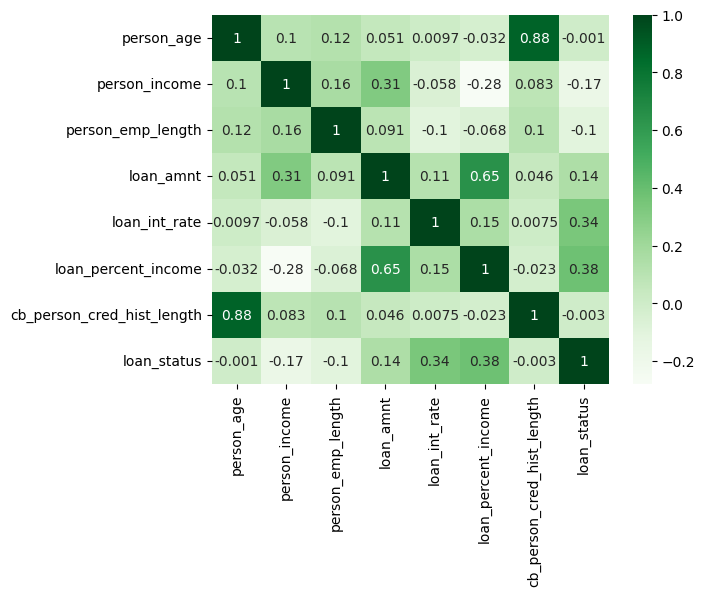

In [ ]:
# Calculate the correlation matrix
corr_features = num_features + ['loan_status']
corr_matrix = cleaned_df[corr_features].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Greens')

In [ ]:
corr_matrix

person_age  person_income  person_emp_length  \
person_age                    1.000000       0.102668           0.123795   
person_income                 0.102668       1.000000           0.164927   
person_emp_length             0.123795       0.164927           1.000000   
loan_amnt                     0.050647       0.310893           0.091024   
loan_int_rate                 0.009670      -0.057631          -0.104538   
loan_percent_income          -0.032121      -0.280311          -0.067596   
cb_person_cred_hist_length    0.876253       0.082785           0.104915   
loan_status                  -0.001033      -0.169960          -0.103053   

                            loan_amnt  loan_int_rate  loan_percent_income  \
person_age                   0.050647       0.009670            -0.032121   
person_income                0.310893      -0.057631            -0.280311   
person_emp_length            0.091024      -0.104538            -0.067596   
loan_amnt                    1.000000       0.113504             0.647282   
loan_int_rate                0.113504       1.000000             0.152152   
loan_percent_income          0.647282       0.152152             1.000000   
cb_person_cred_hist_length   0.045750       0.007538            -0.023214   
loan_status                  0.144897       0.338904             0.378226   

                            cb_person_cred_hist_length  loan_status  
person_age                                    0.876253    -0.001033  
person_income                                 0.082785    -0.169960  
person_emp_length                             0.104915    -0.103053  
loan_amnt                                     0.045750     0.144897  
loan_int_rate                                 0.007538     0.338904  
loan_percent_income                          -0.023214     0.378226  
cb_person_cred_hist_length                    1.000000    -0.003042  
loan_status                                  -0.003042     1.000000

##### Multi-collinearity

In [ ]:
def describe_vif(vif):
    if vif <= 1:
        return "No correlation."
    elif 1 < vif <= 5:
        return "Moderately correlated."
    else:
        return "Highly correlated."



X = cleaned_df.select_dtypes(include='number').iloc[: , 1:-1] # Exclude the target variable
# Calculate VIF for each feature
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Create a DataFrame with VIF values
vif_df = pd.DataFrame({'Feature': X.columns, 'VIF': vif})
# Add a new column with descriptive labels based on VIF
vif_df['VIF_Description'] = vif_df['VIF'].apply(describe_vif)
print(vif_df.sort_values('VIF').reset_index())


   index              Feature        VIF         VIF_Description
0      2    person_emp_length   2.543726  Moderately correlated.
1      1        person_income   6.712531      Highly correlated.
2      4        loan_int_rate  10.100982      Highly correlated.
3      5  loan_percent_income  10.947538      Highly correlated.
4      3            loan_amnt  11.295637      Highly correlated.
5      0           person_age  12.676785      Highly correlated.


####  Categorical Variables and Target Variable

In [ ]:
mapping = {
    'person_home_ownership': 'Home Ownership Status',
    'loan_intent': 'Purpose of the Loan',
    'loan_grade': 'Loan Grade based on Creditworthiness',
    'cb_person_default_on_file': 'Defaulted on Loan in the past'
}

# Create a dictionary with list values as keys and new mappings as values
mapping_cat_dict = {feature: mapping[feature] for feature in cat_features_1}

for key, val in mapping_cat_dict.items():
  loan_status_grade_counts = cleaned_df.groupby(key)['loan_status'].value_counts().reset_index(name='count')
  loan_status_grade_counts['loan_status'] = loan_status_grade_counts['loan_status'].map({0: 'Denied', 1: 'Approved'})


  # Create a bar plot
  fig = px.bar(loan_status_grade_counts, x=key, y='count', color='loan_status', barmode='group')
  # Update x and y labels and title
  fig.update_layout(
      xaxis_title=f'{val}',
      yaxis_title='Number of Loans',
      title=f"Distribution of Loan Status by '{val}'",
      legend_title='Loan Status',
      width=600,  # Set width to 600 pixels
      height=400   # Set height to 400 pixels
  )

  # Define a color dictionary for 'Denied' and 'Approved'
  colors = {'Denied': 'darkred', 'Approved': 'green'}

  # Update trace colors based on the dictionary
  fig.for_each_trace(lambda trace: trace.update(marker_color=colors[trace.name]))
  fig.show()



##### <u>Observations</u>
* **Home Ownership status** : This feature is a signifcant factor in loan approvals. Mortgage holders have the highest approval rates and Renters have the highest rejection rate.
* **Purpose of the Loan**: Education and Medical loans are the most sought-after loan purposes, while Medical loans have the highest approval rates.
* **Loan Grade**: High risk borrowers applicants are minimal. The higher grade applicants A and B have the highest rejections. There are more loan approvals than rejections for below_average creditworthiness borrowers E and F:
* **Default on Loan in Past**: While more loans were approved for borrowers that have not defaulted on past payments, more borrowers who had not defaulted were rejected than those who had not. It seems defaulting on past loan payments is not such a significant factor in loan approval.

## Data Preprocessing


### Train/test split

In [ ]:
X = cleaned_df.drop(columns='loan_status', axis=1)
y = cleaned_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y,random_state=42)

In [ ]:
cat_features_1

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

### Feature Scaling & Transformation

In [ ]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Create a Column Transformer from defined pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features_1)
    ])

preprocessor


ColumnTransformer(transformers=[('num', RobustScaler(),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [ ]:
# Apply preprocessing to your data
X_train_arr = preprocessor.fit_transform(X_train)
X_test_arr = preprocessor.transform(X_test)
new_columns = preprocessor.get_feature_names_out()
X_train_processed = pd.DataFrame(X_train_arr, columns=new_columns)
X_test_processed = pd.DataFrame(X_test_arr, columns=new_columns)

# Model building

## Baseline Model with ALL features

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize classifier
gbc = GradientBoostingClassifier(random_state=42)

# Fit the model
gbc.fit(X_train_processed, y_train)

# Make predictions
y_pred = gbc.predict(X_test_processed)

# Evaluate model using f1-score
f1_score_all = f1_score(y_test, y_pred, average='weighted')

# Evaluate model using roc_auc_scoreroc_auc_score_all = roc_auc_score(y_test, y_pred, average='weighted')
roc_auc_score_all = roc_auc_score(y_test, y_pred, average='weighted')
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score_all:.3f}")
print(f"ROC AUC Score: {roc_auc_score_all:.3f}")

Accuracy score: 0.947
F1-score: 0.944
ROC AUC Score: 0.843


<b>Use predicted probabilities instead of predictions</b>:The project specifies using <font color=blue>"predicted probabilities"</font> for the ROC AUC score calculation. While gbc.predict() gives class labels, ROC AUC requires the <font color=green><b>model's confidence scores</b> for each class (probability of belonging to a class)</font>.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score

# Initialize classifier
gbc = GradientBoostingClassifier(random_state=42)

# Fit the model
gbc.fit(X_train_processed, y_train)

# Make predictions (get probabilities)
y_pred_proba = gbc.predict_proba(X_test_processed)[:, 1]  # Class of interest is 1 prob(Loan being Accepted)

# Evaluate model using roc_auc_score on the test data
roc_auc_score_all = roc_auc_score(y_test, y_pred_proba, average='weighted')

# Round the probabilities to 2 decimal places
y_pred_proba_rounded = np.round(y_pred_proba, 2)


print(f"ROC AUC Score: {roc_auc_score_all:.4f}")
y_pred_proba_rounded = np.round(y_pred_proba, 2)


In [ ]:
results_all = pd.DataFrame({"id": X_test["id"],"actual_loan_status": y_test, "predicted_loan_status": y_pred_proba_rounded}).sort_values("id")
results_all.tail()

id actual_loan_status  predicted_loan_status
58622  58622                  0                   0.13
58633  58633                  0                   0.06
58636  58636                  0                   0.07
58637  58637                  0                   0.01
58640  58640                  0                   0.13

In [ ]:
FN  = len(results_all[(results_all['actual_loan_status'] == 1) & (results_all['predicted_loan_status'] <0.5)])
TP = len(results_all[(results_all['actual_loan_status'] == 1) & (results_all['predicted_loan_status'] >=0.5)])
FNR = (FN / (FN + TP))* 100 # perc of positive misclassifications
print(f"Percentage of Positive class('Approved') misclassifications: {FNR:.2f}%")

FP = len(results_all[(results_all['actual_loan_status'] == 0) & (results_all['predicted_loan_status'] >=0.5)])
TN = len(results_all[(results_all['actual_loan_status'] == 0) & (results_all['predicted_loan_status'] <0.5)])
FPR = (FP / (FP + TN))* 100 # perc of negative misclassifications
print(f"Percentage of Negative class ('Declined') misclassifications: {FPR:.2f}%")

Percentage of Positive class('Approved') misclassifications: 29.98%
Percentage of Negative class ('Declined') misclassifications: 1.23%


## Model Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score


models = [LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42),
          GradientBoostingClassifier(random_state=42),
          RandomForestClassifier(),
          LogisticRegression(random_state=42, solver='liblinear')]

model_names = ["Light Gradient Boosting Classifier",
               "XGBClassifier",
               "Gradient Boosting Classifier",
               "Random Forest Classifier",
               "Logistic Regression"]




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Info] Number of positive: 5844, number of negative: 35205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 41049, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142366 -> initscore=-1.795773
[LightGBM] [Info] Start training from score -1.795773


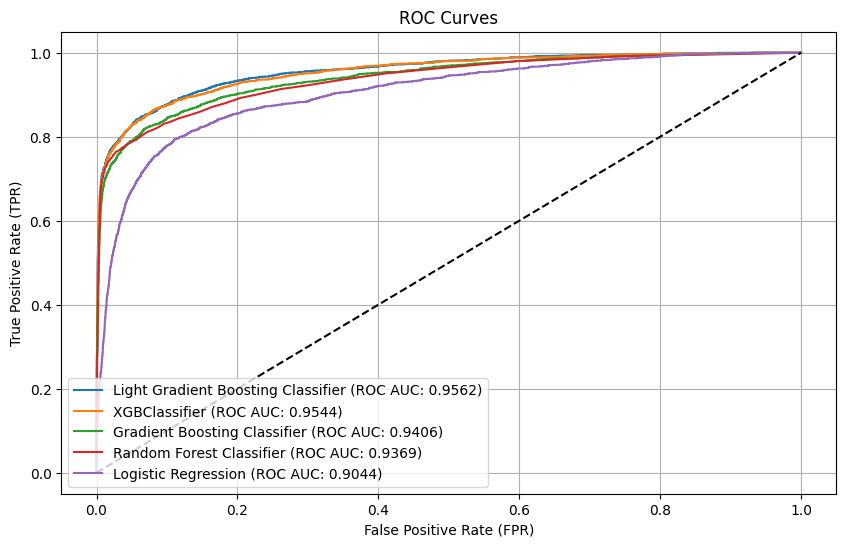

In [ ]:
## Plot setup
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    ## Train the model
    model.fit(X_train_processed, y_train)

    ## Get probabilities
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]  # Probabilities for the positive class

    ## Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    ## False positive rate (FPR) and True positive rate (TPR)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    ## Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_names[i]} (ROC AUC: {roc_auc:.4f})")

## Label and show the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')  # Add diagonal line for reference
plt.show()


##### <u>Observations</u>

* <b>Independence from class imbalance</b>: The ROC AUC score is not affected by class imbalance, making it a valuable metric for evaluating models on imbalanced datasets.

* A larger AUC indicates means the  model is more effective at distinguishing between positive and negative instances.


In [ ]:
# Apply SMOTE to balance the classes
oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_processed, y_train)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resampled, y_resampled, test_size=0.3,random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid to search

param_grid = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1]
}

# Create the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_1, y_train_1)

# Get the best parameters and best score
best_params = grid_search.best_params_

best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best ROC AUC score:", np.round(best_score, 3))


Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best ROC AUC score: 0.992


# Build & Evaluate Model on test and unseen data

## Evaluating the Optimized Model on labelled test data

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef

# Initialize classifier
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=200,random_state=42)

# Fit the model
gbc.fit(X_train_1, y_train_1)

# Make predictions (get probabilities)
y_pred_proba_1 = gbc.predict_proba(X_test_1)[:, 1]  # Class of interest is 1 prob(Loan being Accepted)

# Evaluate model using roc_auc_score on the test data
roc_auc_score_1 = roc_auc_score(y_test_1, y_pred_proba_1)
print(f"ROC AUC Score: {roc_auc_score_1:.4f}")

# Convert probabilities to binary predictions for MCC
threshold = 0.5  # You can adjust this threshold based on your needs
y_pred_binary_1 = (y_pred_proba_1 > threshold).astype(int)

# Calculate MCC using binary predictions
mcc = matthews_corrcoef(y_test_1, y_pred_binary_1)
print(f"MCC Score: {mcc:.4f}")

ROC AUC Score: 0.9930
MCC Score: 0.9416


In [ ]:
results_1 = pd.DataFrame({
    'id': X_test['id'],  # Use the original IDs from X_test
    'actual_loan_status': y_test,
    'predicted_loan_status': y_pred_proba_1[:len(y_test)]  # Slice y_pred_proba to match y_test length
})
results_1[results_1['predicted_loan_status'] >= 0.5].tail()

id actual_loan_status  predicted_loan_status
52182  52182                  1               0.806521
28251  28251                  0               0.998663
1588    1588                  0               0.996231
16419  16419                  0               0.999736
27017  27017                  0               0.997817

In [ ]:
from sklearn.metrics import classification_report

# Convert probabilities to binary labels (assuming threshold of 0.5 for positive class)
y_pred_binary = (y_pred_proba_1).astype(int)

# Print classification report
print(classification_report(y_test_1, y_pred_binary))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10617
           1       0.00      0.00      0.00     10506

    accuracy                           0.50     21123
   macro avg       0.25      0.50      0.33     21123
weighted avg       0.25      0.50      0.34     21123



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



##### <u>Observations</u>
The classification report shows that the model is highly accurate and effective in predicting class 1 instances which was our class of interest.

## Predicting Loan Approval Probabilities with the Optimized Model

In [ ]:
unseen_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
unseen_data.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                           2  
1                 0.10                         Y                           4  
2                 0.13                         Y                           2  
3                 0.14                         N                           7  
4                 0.15                         Y                           4

### Apply Preprocessing

In [ ]:
unseen_data_arr = preprocessor.transform(unseen_data)
new_columns = preprocessor.get_feature_names_out()
unseen_data_processed = pd.DataFrame(unseen_data_arr, columns=new_columns)
y_test_proba = gbc.predict_proba(unseen_data_processed)[:, 1]
y_test_proba_rounded = np.round(y_test_proba, 4)

In [ ]:
unseen_data['loan_status'] = y_test_proba_rounded
submission_df = unseen_data[['id', 'loan_status']]
submission_df.head()

id  loan_status
0  58645       0.9981
1  58646       0.0029
2  58647       0.6189
3  58648       0.0089
4  58649       0.1057

In [ ]:
submission_df.to_csv('submission.csv', index=False)